In [3]:
# -*- coding: utf-8 -*-

data_path='C:\AnatArzData\Data\\rerefrenced'
data_path1='C:\AnatArzData\Data\RDMs_and_distances_results'
data_path2='C:\AnatArzData\Data\EEG_data_for_analysis'


import numpy as np
import os
import mne
from mne import io
from tqdm import tqdm
import gc
import matplotlib
import matplotlib.pyplot as plt


subjects = ['32','35','38']

tones = ['T650','T1098','T2413','T3137','O650','O1428','O1856','O2413','O3137']

In [4]:
###############################################################################
""" Import EEG data from MATLAB format """
###############################################################################
def _import(subj_id):
    gc.collect()
    """ Define paths """

    subject_setfile_wake_n = data_path + '/s_' + subj_id + '_wake_night_referenced.set'   # wake night
    subject_setfile_sleep = data_path + '/s_' + subj_id + '_sleep_referenced.set'         # sleep (sleep1_rsam only subject 5)
    #subject_setfile_wake_m = data_path + '/s_' + subj_id + '_wake_morning_int.set' # wake morning

    """ Read MATLAB files """

    epochs_w_ngt_currSub = io.read_epochs_eeglab(subject_setfile_wake_n, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None) # epochs_w_ngt.info to see the data structure
    epochs_sleep_currSub =  io.read_epochs_eeglab(subject_setfile_sleep, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None)
    #globals()['epochs_w_m'+subj_id] = mne.read_epochs_eeglab(subject_setfile_wake_m, events=None, event_id=None, montage=None, eog=(),verbose=None, uint16_codec=None)

    """ For each state create a loop which loads and categorize the events opportunely """
    """ Note that the except KeyError was introduced because some events were missing,
    causing a KeyError to appear """

    ########################
    #AWAKE NIGHT
    for value, j in enumerate(tones):
        ep_wakengt_currSub_currTone=[] #list of epochs data categorized by state, subject, and tone
        EEG_WN_currSub_currTone = []# list of EEG data categorized by state, subject, and tone
        try:
            for k in range(0,10): # note that the MATLAB EEG file is of the shape (n trials, n electrodes, n time points)
                try:
                    """ List of epochs """
                    ep_wakengt_currSub_currTone.append(epochs_w_ngt_currSub[str(j)+'_'+ str(k)]) # in the IPython console type: i.e, ep_wngt_02_T500
                    ep_wakenight_currSub_currTone = mne.concatenate_epochs(ep_wakengt_currSub_currTone)

                    """ List of EEG data """
                    EEG_WN_currSub_currTone.append(np.swapaxes(epochs_w_ngt_currSub[str(j)+'_'+ str(k)].get_data(),1,2))
                    EEG_WNT_currSub_currTone=np.concatenate(EEG_WN_currSub_currTone, axis=0)

                    """ Save EEG data """
                    #np.save(os.path.join(data_path2,'EEG_WNGT_'+subj_id+'_'+j),EEG_WN_currSub_currTone)

                except KeyError:
                    continue
            evoked_wngt_currSub_currTone= (ep_wakenight_currSub_currTone).average() #average all epochs corresponding to a tone for each subject

            """ Save evoked data """
            np.save(os.path.join(data_path1,'evoked_wngt_'+subj_id+'_'+str(j)),evoked_wngt_currSub_currTone)

        except KeyError:
            continue
    ##########################
    # SLEEP
    # stages: N1, N2, N3
    for i in range(1,4): # number corresponding to the N stage (between 1 and 3)
        for value, j in enumerate(tones):
            ep_sleepN_currSubToneStage = []
            EEG_N_currSubToneStage = []
            try:
                for k in range(0,10):
                    try:

                        """ List of epochs """
                        ep_sleepN_currSubToneStageTrial = epochs_sleep_currSub['N'+str(i)+str(j)+'_'+str(k)]

                        ep_sleepN_currSubToneStage.append(ep_sleepN_currSubToneStageTrial)
                        evoked_currSubToneStage =mne.concatenate_epochs(ep_sleepN_currSubToneStage)

                        """ List of EEG data """
                        EEG_N_currSubToneStage.append(np.swapaxes(ep_sleepN_currSubToneStageTrial.get_data(),1,2))
                        EEG_SN_currSubToneStage =np.concatenate(EEG_N_currSubToneStage, axis=0)

                        """ Save EEG data """
                        #np.save(os.path.join(data_path2,'EEG_SN_'+subj_id+'_N'+str(i)+str(j)),EEG_SN_currSubToneStage)

                    except KeyError:
                        continue

                evoked_sleep_currSubToneStage = (evoked_currSubToneStage).average() #to plot!!   #evoked_sleep06_N1T500

                """ Save evoked data """
                np.save(os.path.join(data_path1,'evoked_SN_'+subj_id+'_N'+str(i)+str(j)),evoked_sleep_currSubToneStage)
            except KeyError:
                continue
                #####


    # stages: Rp, Rt
    REM=['Rp','Rt']
    for value, i in enumerate(REM):
        for value, j in enumerate(tones):
            ep_sleepREM_currSubToneStage = []
            EEG_REM_currSubToneStage = []
            evoked_sleep_REM_currSubToneStage = []
            EEG_bothREM_currSubToneStage = []
            try:
                for k in range(0,10):
                    try:

                        """ List of epochs """
                        ep_sleepREM_currSubToneStage.append(epochs_sleep_currSub[str(i)+str(j)+'_'+ str(k)])
                        globals()['evoked_'+subj_id+'_'+str(i)+str(j)]=mne.concatenate_epochs(ep_sleepREM_currSubToneStage)

                        """ List of EEG data """
                        EEG_REM_currSubToneStage.append(np.swapaxes(epochs_sleep_currSub[str(i)+str(j)+'_'+ str(k)].get_data(),1,2))
                        globals()['EEG_SREM_'+subj_id+'_'+str(i)+str(j)]=np.concatenate(EEG_REM_currSubToneStage, axis=0)

                        """ Save EEG data """
                        np.save(os.path.join(data_path2,'EEG_SREM_'+subj_id+'_'+str(i)+str(j)),globals()['EEG_SREM_'+subj_id+'_'+str(i)+str(j)])

                    except KeyError:
                        continue

                # NOTICE SHARON: this is where the REM thingies may get tangled.
                globals()['evoked_sleep'+subj_id+'_'+str(i)+str(j)]=(globals()['evoked_'+subj_id+'_'+str(i)+str(j)]).average()

                """ Save evoked data """
                np.save(os.path.join(data_path1,'evoked_SREM_'+subj_id+'_'+str(i)+str(j)),globals()['evoked_sleep'+subj_id+'_'+str(i)+str(j)])

            except KeyError:
                continue
    return
###############################################################################
######### Load data and define conditions for each subject ####################
###############################################################################
with tqdm(total=len(subjects)) as pbar:
    for s, subject in enumerate(subjects):
        _import(subject)
        pbar.write('processed: %d' %s)
        pbar.update(1)

  0%|          | 0/3 [00:00<?, ?it/s]

Extracting parameters from C:\AnatArzData\Data\rerefrenced\s_32_wake_night_referenced.set...


C:\Users\Sharon\AppData\Local\Temp\ipykernel_21072\400512291.py:14: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  epochs_w_ngt_currSub = io.read_epochs_eeglab(subject_setfile_wake_n, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None) # epochs_w_ngt.info to see the data structure


Not setting metadata
4729 matching events found
No baseline correction applied
0 projection items activated
Ready.


C:\Users\Sharon\anaconda3\Lib\site-packages\pymatreader\utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from C:\AnatArzData\Data\rerefrenced\s_32_sleep_referenced.set...


C:\Users\Sharon\AppData\Local\Temp\ipykernel_21072\400512291.py:15: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  epochs_sleep_currSub =  io.read_epochs_eeglab(subject_setfile_sleep, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None)


Not setting metadata
25184 matching events found
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
24 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
48 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
72 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
96 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
120 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
141 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
161 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
181 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
201 matching events found
No baseline correction applied
0 bad epochs dropp

 33%|███▎      | 1/3 [15:29<30:59, 929.88s/it]

processed: 0


C:\Users\Sharon\anaconda3\Lib\site-packages\pymatreader\utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from C:\AnatArzData\Data\rerefrenced\s_35_wake_night_referenced.set...


C:\Users\Sharon\AppData\Local\Temp\ipykernel_21072\400512291.py:14: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  epochs_w_ngt_currSub = io.read_epochs_eeglab(subject_setfile_wake_n, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None) # epochs_w_ngt.info to see the data structure


Not setting metadata
4779 matching events found
No baseline correction applied
0 projection items activated
Ready.


C:\Users\Sharon\anaconda3\Lib\site-packages\pymatreader\utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from C:\AnatArzData\Data\rerefrenced\s_35_sleep_referenced.set...


C:\Users\Sharon\AppData\Local\Temp\ipykernel_21072\400512291.py:15: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  epochs_sleep_currSub =  io.read_epochs_eeglab(subject_setfile_sleep, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None)


Not setting metadata
28937 matching events found
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
24 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
48 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
72 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
96 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
120 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
140 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
160 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
181 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
204 matching events found
No baseline correction applied
0 bad epochs dropp

 67%|██████▋   | 2/3 [32:24<16:19, 979.84s/it]

processed: 1


C:\Users\Sharon\anaconda3\Lib\site-packages\pymatreader\utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from C:\AnatArzData\Data\rerefrenced\s_38_wake_night_referenced.set...


C:\Users\Sharon\AppData\Local\Temp\ipykernel_21072\400512291.py:14: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  epochs_w_ngt_currSub = io.read_epochs_eeglab(subject_setfile_wake_n, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None) # epochs_w_ngt.info to see the data structure


Not setting metadata
4747 matching events found
No baseline correction applied
0 projection items activated
Ready.


C:\Users\Sharon\anaconda3\Lib\site-packages\pymatreader\utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from C:\AnatArzData\Data\rerefrenced\s_38_sleep_referenced.set...


C:\Users\Sharon\AppData\Local\Temp\ipykernel_21072\400512291.py:15: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  epochs_sleep_currSub =  io.read_epochs_eeglab(subject_setfile_sleep, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None)


Not setting metadata
24419 matching events found
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
24 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
48 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
71 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
94 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
118 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
141 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
160 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
178 matching events found
No baseline correction applied
0 bad epochs dropped
Not setting metadata
201 matching events found
No baseline correction applied
0 bad epochs dropp

100%|██████████| 3/3 [46:56<00:00, 938.84s/it]

processed: 2


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


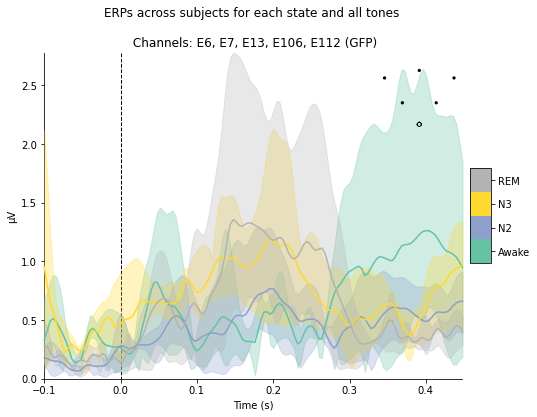

[<Figure size 576x432 with 3 Axes>]

In [5]:
###############################################################################
############ Plot grand average ERP for all tones #############################
""" First, for each state, plot the ERPs averaged across all tones (1 graph)"""

state_ERP_WNGT = []
state_ERP_N2 = []
state_ERP_N3 = []
state_ERP_REM = []
for s, subject in enumerate(subjects):
    ERP_WNGT_currSub = []
    ERP_N2_currSub = []
    ERP_N3_currSub = []
    ERP_REM_Rp_currSub = []
    ERP_REM_Rt_currSub = []
    ERP_REM_currSub = []
    for value, j in enumerate(tones):
        """ Load saved data """
        """ Awake night """
        evoked_wngt_currSubTone = np.load(os.path.join(data_path1,'evoked_wngt_'+subject+'_'+j+'.npy'),allow_pickle = True)
        ERP_WNGT_currSub.append((evoked_wngt_currSubTone.flatten())[0])
        """ Non REM sleep """
        evoked_SN_N2_currSubTone = np.load(os.path.join(data_path1,'evoked_SN_'+subject+'_N2'+j+'.npy'),allow_pickle = True)
        ERP_N2_currSub.append((evoked_SN_N2_currSubTone.flatten())[0])
        evoked_SN_N3_currSubTone = np.load(os.path.join(data_path1,'evoked_SN_{}_N3{}.npy'.format(subject,j)),allow_pickle = True)
        ERP_N3_currSub.append((evoked_SN_N3_currSubTone.flatten())[0])
        """ REM """
        evoked_SN_Rp_currSubTone = np.load(os.path.join(data_path1,'evoked_SREM_'+subject+'_Rp'+j+'.npy'),allow_pickle = True)
        evoked_SN_Rt_currSubTone = np.load(os.path.join(data_path1,'evoked_SREM_'+subject+'_Rt'+j+'.npy'),allow_pickle = True)
        ERP_REM_Rp_currSub.append((evoked_SN_Rp_currSubTone.flatten())[0])
        ERP_REM_Rt_currSub.append((evoked_SN_Rt_currSubTone.flatten())[0])
    state_ERP_WNGT.append(mne.grand_average(ERP_WNGT_currSub))
    np.save(os.path.join(data_path1,'state_ERP_WNGT'),state_ERP_WNGT)
    state_ERP_N2.append(mne.grand_average(ERP_N2_currSub))
    np.save(os.path.join(data_path1,'state_ERP_N2'),state_ERP_N2)
    state_ERP_N3.append(mne.grand_average(ERP_N3_currSub))
    np.save(os.path.join(data_path1,'state_ERP_N3'),state_ERP_N3)
    ERP_REM_currSub = ERP_REM_Rp_currSub + ERP_REM_Rt_currSub
    state_ERP_REM.append(mne.grand_average(ERP_REM_currSub))
    np.save(os.path.join(data_path1,'state_ERP_REM'),state_ERP_REM)

evokeds = {'Awake':state_ERP_WNGT,'N2':state_ERP_N2,'N3':state_ERP_N3,'REM':state_ERP_REM}
electrodes=[4,5,10,79,84]
cmap = 'Set2'
colors=dict(Awake = 1, N2 = 2, N3 = 3, REM = 4)
mne.viz.plot_compare_evokeds(evokeds,picks=electrodes,cmap=cmap, colors=colors,
                             truncate_xaxis=False, truncate_yaxis=False, split_legend=True, #show_legend='upper left',
                             show_sensors='upper right',
                             title= "ERPs across subjects for each state and all tones \n \n Channels: E6, E7, E13, E106, E112")


combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


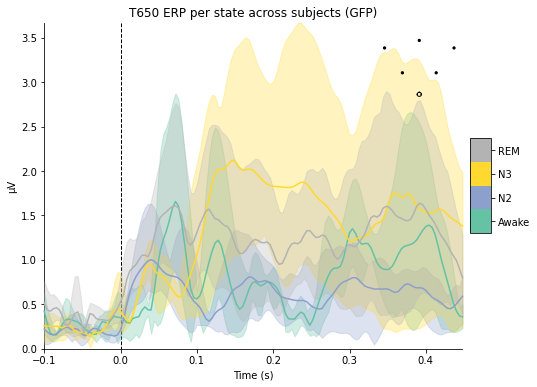

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


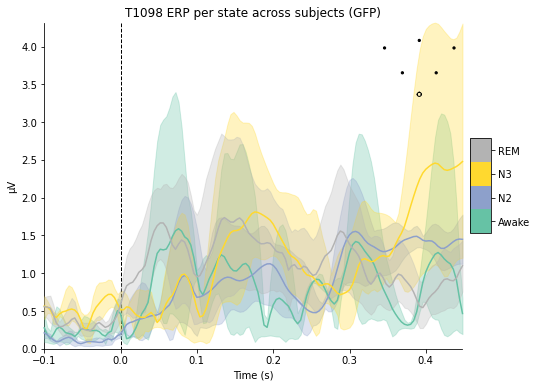

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


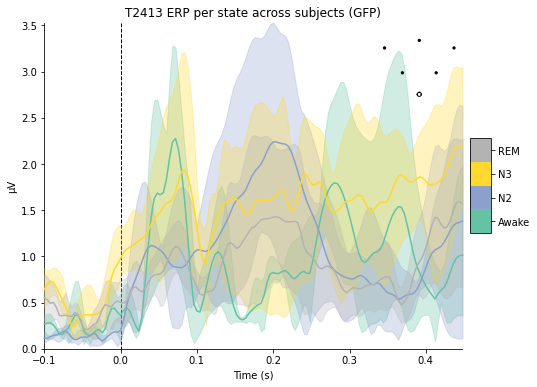

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


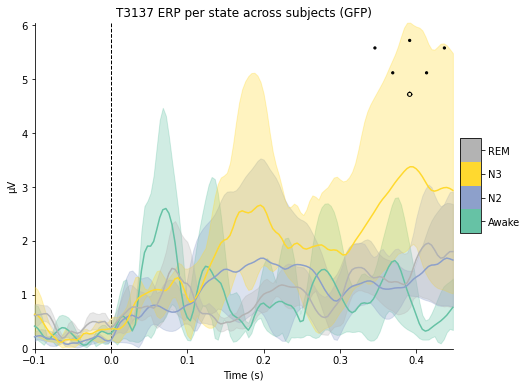

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


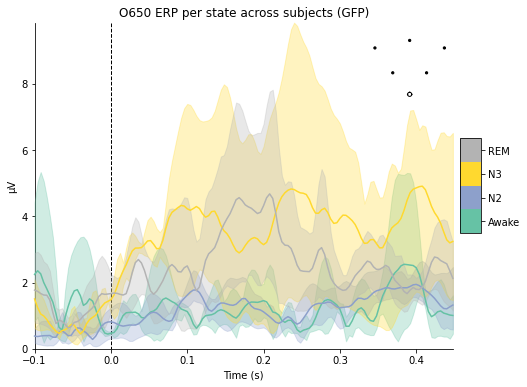

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


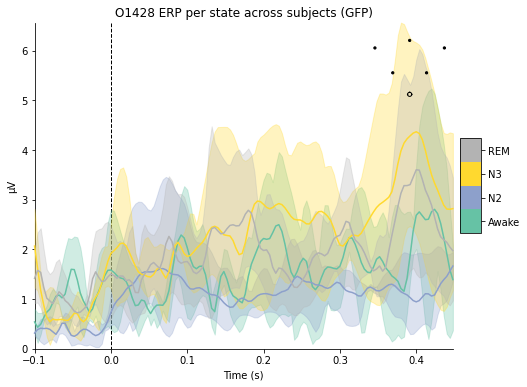

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


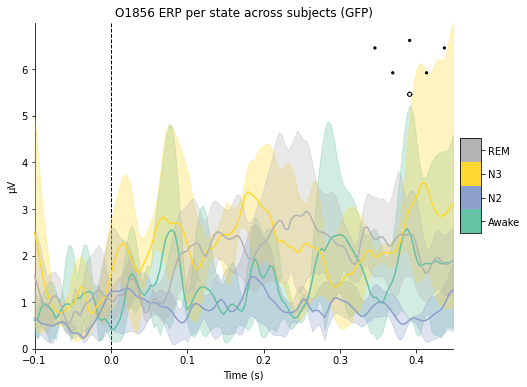

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


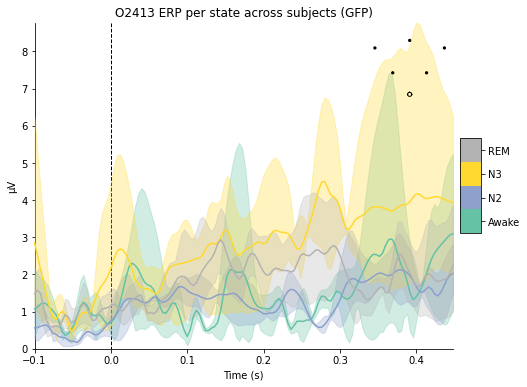

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


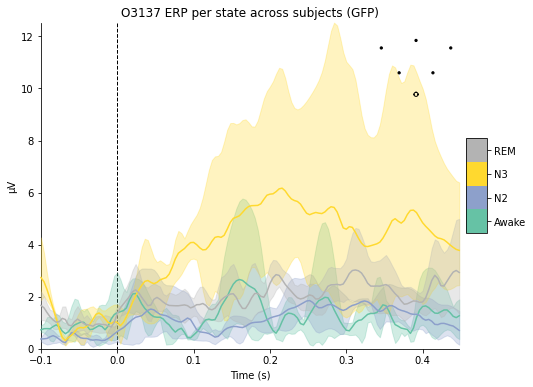

In [6]:

""" Plot the ERPs corresponding to the same tone for all states (9 graphs)"""
for value, j in enumerate(tones):
    globals()['wngt_{}_ERP'.format(j)] = []
    globals()['N2_{}_ERP'.format(j)] = []
    globals()['N3_{}_ERP'.format(j)] = []
    globals()['ERP_REM_Rp{}'.format(j)] = []
    globals()['ERP_REM_Rt{}'.format(j)] = []
    for s, subject in enumerate(subjects):
        """ Awake night """
        globals()['evoked_wngt_{}_{}'.format(subject,j)] = np.load(os.path.join(data_path1,'evoked_wngt_'+subject+'_'+j+'.npy'),allow_pickle = True)
        globals()['wngt_{}_ERP'.format(j)].append((globals()['evoked_wngt_{}_{}'.format(subject,j)].flatten())[0])
        """ Non REM sleep """
        globals()['evoked_SN_{}_N2{}'.format(subject,j)] = np.load(os.path.join(data_path1,'evoked_SN_{}_N2{}.npy'.format(subject,j)),allow_pickle = True)
        globals()['N2_{}_ERP'.format(j)].append((globals()['evoked_SN_{}_N2{}'.format(subject,j)].flatten())[0])
        globals()['evoked_SN_{}_N3{}'.format(subject,j)] = np.load(os.path.join(data_path1,'evoked_SN_{}_N3{}.npy'.format(subject,j)),allow_pickle = True)
        globals()['N3_{}_ERP'.format(j)].append((globals()['evoked_SN_{}_N3{}'.format(subject,j)].flatten())[0])
        """ REM sleep """
        globals()['evoked_SREM_{}_Rp{}'.format(subject,j)] = np.load(os.path.join(data_path1,'evoked_SREM_'+subject+'_Rp'+j+'.npy'),allow_pickle = True)
        globals()['evoked_SREM_{}_Rt{}'.format(subject,j)] = np.load(os.path.join(data_path1,'evoked_SREM_'+subject+'_Rt'+j+'.npy'),allow_pickle = True)
        globals()['ERP_REM_Rp{}'.format(j)].append((globals()['evoked_SREM_{}_Rp{}'.format(subject,j)].flatten())[0])
        globals()['ERP_REM_Rt{}'.format(j)].append((globals()['evoked_SREM_{}_Rt{}'.format(subject,j)].flatten())[0])
        globals()['REM_{}_ERP'.format(j)]= globals()['ERP_REM_Rp{}'.format(j)] + globals()['ERP_REM_Rt{}'.format(j)]
    """ Plots """
    evokeds = {'Awake': globals()['wngt_{}_ERP'.format(j)],'N2':globals()['N2_{}_ERP'.format(j)],
               'N3':globals()['N3_{}_ERP'.format(j)],'REM':globals()['REM_{}_ERP'.format(j)]}
    electrodes=[4,5,10,79,84]
    cmap = 'Set2'
    colors=dict(Awake = 1, N2 = 2, N3 = 3, REM = 4)
    mne.viz.plot_compare_evokeds(evokeds,picks=electrodes,cmap=cmap, colors=colors,
                                 truncate_xaxis=False, truncate_yaxis=False, split_legend=True, #show_legend='upper left',
                                 show_sensors='upper right',
                                 title='{} ERP per state across subjects'.format(j))


In [7]:

""" Plot the ERPs corresponding to the all tones, each state at the time (4 graphs)"""
states = ['wngt','N2','N3','REM']
for i,n in enumerate(states):
    evokeds={
        'T650': globals()['{}_T650_ERP'.format(n)],
             'T845': globals()['{}_T845_ERP'.format(n)],
             'T1098': globals()['{}_T1098_ERP'.format(n)],'T1428': globals()['{}_T1428_ERP'.format(n)],
             'T1856': globals()['{}_T1856_ERP'.format(n)], 'T2413': globals()['{}_T2413_ERP'.format(n)],
             'T3137': globals()['{}_T3137_ERP'.format(n)],'T4079': globals()['{}_T4079_ERP'.format(n)],
             'T5302': globals()['{}_T5302_ERP'.format(n)]
    }
    electrodes=[4,5,10,79,84]
    cmap='winter'
    colors=dict(T650 = 0, T845 = 1, T1098 = 2, T1428 = 3, T1856 = 4, T2413 = 5, T3137 = 6, T4079 = 7, T5302 = 8)
    mne.viz.plot_compare_evokeds(evokeds, picks=electrodes, cmap=cmap, colors=colors,
                                 truncate_xaxis=False, truncate_yaxis=False, split_legend=True, #show_legend='upper left',
                                 show_sensors='upper right',
                                 title='{} : ERP for each tone across subjects'.format(n))

KeyError: 'wngt_T845_ERP'